<a href="https://colab.research.google.com/github/savula13/ProjectsInMLandAI/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
Saipranav Avula

In [4]:
import pandas as pd
import seaborn as sn
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
from kerastuner.tuners import RandomSearch
from sklearn import model_selection as ms
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  if __name__ == '__main__':


# Research

For implementing a 2-layer neural network, I used Tensorflow and I specifically used the Keras framework.
With Keras, I learned how to instantiate a model with a set number of input nodes using the Model class. 
From the Keras documentation, I learned how to use the Sequential class to manually add hidden
and output layers to the insantiated model. In this documentation, it also details how to set the activation
functions for each layer. 

The Functional API for Keras allows a user to create more complex models than the Sequential class, which is not
as applicable for this particular assignment, but it has functionality to obtain model summaries and model visualizations
which are useful in evaluating models.

Keras also has a class for hyperparameter tuning. I used the documentation for the Tuner class to learn about how different
methods such as RandomSearch, Hyperband, and Bayesian Optimization can be used to find the optimal hyperparameters such as 
the number of nodes in the hidden layers, the number of hidden layers, learning rate, momentum, etc.



## Links
https://keras.io/guides/functional_api/

https://keras.io/api/models/sequential/

https://keras.io/api/models/model/

https://keras.io/getting_started/intro_to_keras_for_engineers/

https://keras.io/api/keras_tuner/tuners/random/

https://www.tensorflow.org/tutorials/keras/keras_tuner

https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-deep-neural-nets-by-example-685cb5429a38

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/



# Part 2
## 1. Exploratory Data Analysis
The dataset I am using is based on Stellar Classification which uses the spectral data of stars to categorize them into different categories.
Specifically the raw data has been processed to use Absolute Magnitude and B-V Color Index to identify Giants and Dwarfs.

https://www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs

In [6]:
df = pd.read_csv("./Star39552_balanced.csv")
df.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1
3,6.54,5.23,0.76,1.189,K1III,15.132508,0
4,8.52,0.96,0.72,0.173,B8V,13.431356,1


In [7]:
df.drop(["SpType"], axis = 1, inplace = True)
rows, cols = df.shape
print("There are {} rows".format(rows))
print("There are {} columns".format(cols))

There are 39552 rows
There are 6 columns


In [8]:
df.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'Amag', 'TargetClass'], dtype='object')

This data has already gone through preprocessing so it is already balanced.

In [9]:
df.TargetClass.value_counts(normalize=True)

1    0.5
0    0.5
Name: TargetClass, dtype: float64

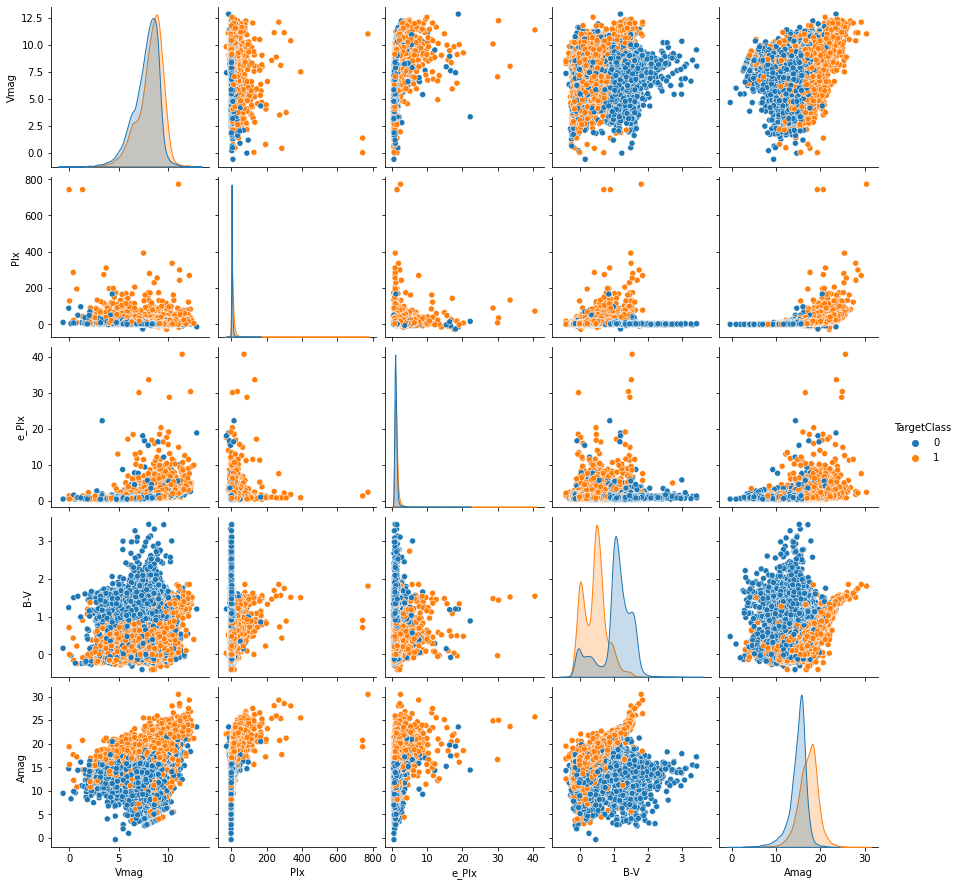

In [10]:
sn.pairplot(df, hue = "TargetClass")

In [11]:
X = df.iloc[:, 0:cols-1]
Y = df.iloc[:, cols-1]
Y.head()

0    1
1    0
2    1
3    0
4    1
Name: TargetClass, dtype: int64

## 2. Train Dev Test Split

In [12]:
X_train, X_temp, Y_train, Y_temp = ms.train_test_split(X, Y, test_size = 0.3, random_state= 42)
X_temp.shape

(11866, 5)

In [13]:
X_test, X_dev, Y_test, Y_dev = ms.train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [14]:
Y_test.shape

(5933,)

# 3. Forward Propogation

For the forward propogation, I am using the relu activation function for the first 2 layers of the model (input and first).

Since it is linear for values greater than 0, the relu is a common and good choice of activation functon. 
and the sigmoid activation is used for the output layer so that the outputs are between 0 and 1. 

In this case the number of layer nodes is manually set. Hyperparameter tuning is implemented later to determine the optimal number of layer nodes.

In [15]:
init_model = tf.keras.Sequential()
init_model.add(Dense(12, input_shape=(cols-1,), activation='relu'))
init_model.add(Dense(6, activation='relu'))
init_model.add(Dense(1, activation='sigmoid'))

# 4 & 5. Cost Function and Gradient Descent

Gradient descent is implemented using binary cross-entropy as the loss function. Since the target variable (giant star or dwarf star) is binary, 
binary cross-entropy is an ideal choice since it is usually used for binary classifcation problems. This includes optimizing the cost function over the layers as well

The Adam optimizer is used, which uses the past gradients to calculate the current gradient and is commonly used in training neural nets. Since it 
has built in tuning it is a good option to choose as optimizer.

In [16]:
init_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Below, the neural network is trained on teh training data. Then it is validated on the dev set.

In [17]:
Xt = tf.convert_to_tensor(X_train)
Yt = tf.convert_to_tensor(Y_train)
init_model.fit(Xt, Yt, epochs = 10, batch_size=500)
init_model.fit(X_train, Y_train, epochs= 10, validation_data=(X_dev, Y_dev))

Epoch 1/10
56/56 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.6629
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 0.5962 - accuracy: 0.6907
Epoch 3/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5465 - accuracy: 0.7200
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 0.4969 - accuracy: 0.7606
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8102
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8429
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 0.3609 - accuracy: 0.8654
Epoch 8/10
56/56 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.8723
Epoch 9/10
56/56 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.8741
Epoch 10/10
56/56 [==============================] - 0s 2ms/step - loss: 0.3317 - accuracy: 0.8761
Epoch 1/10
866/866 

Once the neural network is trained and validated initially, then the predictions made by the model are evaluated using the test set.

In [18]:
acc_temp = init_model.evaluate(X_test, Y_test)

print("The accuracy with this initial neural network configuration is {}".format(acc_temp[1]))

186/186 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.8744
The accuracy with this initial neural network configuration is 0.8744311332702637


# Task 3

Now that the neural network has been initialized, the optimal hyperparameters can be found using RandomSearch. Keras has a Tuner
class that makes it relatively simple to implement RandomSearch with given constraints of hyperparameters.

I chose this method to choose the optimal hyperparameters because it is more efficient and generally as effective as GridSearch.

I also chose the Adam optimizer as in other machine learning research, Adam has proven to be an effective optimizer that tunes itself.

The varied hyperparameters are:

1. Nodes in First Hidden Layer
2. Nodes in Second Hidden Layer
3. Learning rate

I did not use regularization because as seen in the inital runs,
the accuracy on the training sets is similar to when it is validated using the dev sets (70% accuacy on training vs 83% accuracy on dev).
Therefore, there is no concern that the model is overfitting.

In [19]:
def build_model(hp):
    
    first_layer = hp.Int(name = 'first_layer', min_value = 16, max_value = 128, step = 16)
    second_layer = hp.Int(name = 'second_layer', min_value = 16, max_value = 64, step = 16)

    #Forward Propogation 

    #Creating neural network layers with dropouts
    model = tf.keras.Sequential()
    #input and first hidden layer
    model.add(Dense(units = first_layer, input_shape=(5,), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    #second hidden layer
    model.add(Dense(units = second_layer, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    #output layer
    model.add(Dense(1, activation='sigmoid'))

    #choices for learning rate 
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    #Cost Function and Gradient Descent Implementation
    #configuring model with choices from above
    model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), metrics=['accuracy'])

    return model

Once the RandomSearch and model are configured, the model is fit on the training data and then validated using the dev set. The RandomSearch tunes the parameters
after every iteration of the validation on the dev set.

In [21]:
tuner = kt.RandomSearch(build_model, objective = 'val_accuracy', max_trials = 5, directory = 'temp2',
project_name = 'random_search') 

#fitting model on training data, validating using dev set, and tuning after each iteration
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_dev, Y_dev))

Trial 5 Complete [00h 00m 37s]
val_accuracy: 0.8751053214073181

Best val_accuracy So Far: 0.8756110072135925
Total elapsed time: 00h 00m 37s


Once the Random Search is done, then the best hyperparameters for the model are found.

In [22]:
#returing best hyperparameters to use in final model
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0] 
print(f"""
The hyperparameter search has been completed. 
The optimal number of layers in the first densely-connected
layer is {best_hyperparameters.get('first_layer')}. The optimal number of layers in the second densely-connected layer is {best_hyperparameters.get('second_layer')}. 
The optimal learning rate for the optimizer is {best_hyperparameters.get('learning_rate')}.
""")


The hyperparameter search has been completed. 
The optimal number of layers in the first densely-connected
layer is 64. The optimal number of layers in the second densely-connected layer is 48. 
The optimal learning rate for the optimizer is 0.001.



A final neural network model is built with the best hyperparameters from the random search. It is then fit on the training set and validated using the dev set.

In [23]:

model = tuner.hypermodel.build(best_hyperparameters)

model.fit(X_train, Y_train, epochs= 10, validation_data=(X_dev, Y_dev))


Epoch 1/10
866/866 [==============================] - 3s 3ms/step - loss: 0.5210 - accuracy: 0.7674 - val_loss: 0.3481 - val_accuracy: 0.8636
Epoch 2/10
866/866 [==============================] - 2s 3ms/step - loss: 0.3534 - accuracy: 0.8673 - val_loss: 0.3326 - val_accuracy: 0.8716
Epoch 3/10
866/866 [==============================] - 2s 2ms/step - loss: 0.3354 - accuracy: 0.8751 - val_loss: 0.3271 - val_accuracy: 0.8726
Epoch 4/10
866/866 [==============================] - 2s 2ms/step - loss: 0.3300 - accuracy: 0.8765 - val_loss: 0.3386 - val_accuracy: 0.8754
Epoch 5/10
866/866 [==============================] - 2s 2ms/step - loss: 0.3278 - accuracy: 0.8780 - val_loss: 0.3283 - val_accuracy: 0.8702
Epoch 6/10
866/866 [==============================] - 2s 2ms/step - loss: 0.3259 - accuracy: 0.8759 - val_loss: 0.3239 - val_accuracy: 0.8749
Epoch 7/10
866/866 [==============================] - 2s 3ms/step - loss: 0.3257 - accuracy: 0.8784 - val_loss: 0.3231 - val_accuracy: 0.8724
Epoch 

Once the best model is trained and validated, it is evauluated using the test data.

In [24]:
_, acc = model.evaluate(X_test, Y_test)

print("The accuracy of the neural network with the optimal hyperparameters when evaluated on the test set is {}".format(acc))
print(acc)

186/186 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.8761
The accuracy of the neural network with the optimal hyperparameters when evaluated on the test set is 0.8761166334152222
0.8761166334152222


# Task 4

I am creating a logistic regression model to compare its performance with the neural network peformance. Logistic regression is ideal for binary classification and we have used it for previous binary classifcaiton problems

In [25]:
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

LogisticRegression()

In [26]:
Y_pred = lr_model.predict(X_test)

test_accuracy = metrics.accuracy_score(Y_test, Y_pred)

print("The accuracy of the logistic regression model when evaluated on the test set is {}".format(test_accuracy))

The accuracy of the logistic regression model when evaluated on the test set is 0.8767908309455588


## Comparison

The accuracy of the nerual network model is .8756 87.6%$ (in my testing).

The accuracy of the logistic regression model is .877 ~ 87.7% (in my testing).

Therefore, the models are achieving the same accuracy on the same training and test sets.
One reason that they have the same performance is that there is not a large number of features/columns
in the dataset. Neural networks tend to have substantial improvement over other models when using unstructured
data or data with many input features. Therefore, it makes sense that a simpler model such as Logistic Regression is
able to achieve very similar accuracy. 

Another factor could be that the neural network I used had 2 hidden layers. If a network with more layers was chosen it could've
led to a more substantial improvement over the Logistic Regression.